# Basic Approach for Trace Clustering
## Kmeans + One Hot Encoding

Requirements:
- ~~implement basic approach (one-hot-enconding + kmeans)~~
- ~~hyperparameter experiments (grid-search)~~
- ~~interpretation of clusters (one municipal? etc.)~~
- ~~Notebook nicely presenting the clustering results for different hyperparameters~~

In [1]:
import pandas as pd

from practical.ProcessMining.group1.shared import utils
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.objects.conversion.log import converter as log_converter
from sklearn import metrics
from joblib import Parallel, delayed
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

BASE = utils.SAMPLES_PATH
real_path = BASE / "DomesticDeclarations_cleansed.csv"
event_log_raw = utils.import_csv(BASE / "DomesticDeclarations_cleansed.csv")

In [2]:
def filter_rare_traces(log, threshold=2):
    case_counts = log.groupby('case:concept:name').size()
    frequent_traces = case_counts[case_counts >= threshold].index
    
    filtered_event_log = log[log['case:concept:name'].isin(frequent_traces)]
    return filtered_event_log

def split_by_date(log, date="2018"):
    date = pd.to_datetime(date).tz_localize('UTC')
    
    return log[log['time:timestamp'] < date], log[log['time:timestamp'] >= date]

def get_activities(log):
    return list(log['concept:name'].unique())

def get_df_by_traces(log):
    return log.groupby('case:concept:name')["concept:name"].apply(list).reset_index()

def hot_encode_traces(log, traces_df):
    traces = traces_df["concept:name"].to_list()
    all_activities = get_activities(log)
    
    # One-hot encode the event log
    one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[all_activities], handle_unknown='ignore')
    one_hot_encoder.fit(np.array(all_activities).reshape(-1, 1))
    
    # Using dictionary comprehension to encode traces
    encoded_traces = [one_hot_encoder.transform(np.array(trace).reshape(-1, 1)).sum(axis=0) for trace in traces]
    
    # Stacking the encoded traces to form a sampled event log
    return np.vstack(encoded_traces)

def custom_metrics(log, _encoded_log, cluster, petri_net, init_marking, final_marking, weights=None):
    if weights is None:
        weights = {"ss": 0.4, "f": 0.25, "p": 0.35}
    
    ss = metrics.silhouette_score(_encoded_log, cluster)
    
    fitness = pm4py.conformance.fitness_alignments(log, petri_net, init_marking, final_marking)["averageFitness"]
    precision = pm4py.conformance.precision_alignments(log, petri_net, init_marking, final_marking)

    return weights["ss"] * ss + weights["f"] * fitness + weights["p"] * precision

def split_by_cluster(_event_log):
    _cluster_sublogs = {}
    for _cluster_label in np.unique(_event_log['cluster']):
        _cluster_sublogs[_cluster_label] = _event_log[_event_log['cluster'] == _cluster_label]
        
    _cluster_sublogs_sorted = dict(reversed(sorted(_cluster_sublogs.items(), key=lambda item: item[1]['case:concept:name'].nunique())))
    
    return _cluster_sublogs_sorted


def export_sublogs_to_csv(cluster_sublogs, folder="base_approach"):
    os.makedirs(folder, exist_ok=True)
    
    cluster_sublogs = {k: cluster_sublogs[k] for k in sorted(cluster_sublogs)}
    for cluster_label, df in cluster_sublogs.items():
        file_path = os.path.join(folder, f"cluster_{cluster_label}.csv")
        df.to_csv(file_path,sep=';',index=False)
    
    print(f"Clusters exported to /{folder}")

## Event log preprocessing

As first step, we filter out rare traces, which are not appearing at least twice in the event log. This is done to avoid overfitting of the clustering algorithm.

Since we realized, that the event log contains event, which stopped appearing after 2018 (e.g. due to changes in the process), we split the event log into two parts: before 2018 and from 2018. In the end we compare the clusters of both versions as of the unsplitted log to see if the clustering algorithm can detect the change in the process.

In [3]:
event_log_preprocessed = filter_rare_traces(event_log_raw, threshold=2)

before_2018, from_2018 = split_by_date(event_log_preprocessed, "2018")
before_2018 = filter_rare_traces(before_2018, threshold=2)
from_2018 = filter_rare_traces(from_2018, threshold=2)

LOG_VERSIONS = [event_log_preprocessed, from_2018, before_2018]

## Event log sampling and encoding

To reduce the computational effort, we sample 1000 traces from the event log and encode them using one-hot-encoding.

In [4]:
event_log_sampled = event_log_preprocessed.sample(n=1000)

# Group traces by case and encode them as hole as one-hot vectors
traces = get_df_by_traces(event_log_sampled)

encoded_log = hot_encode_traces(event_log_preprocessed, traces)

## Parameter tuning for KMeans

To find the best hyperparameters for the KMeans clustering algorithm, we use a grid search approach. We evaluate the performance of each parameter combination using a custom metric, which is a combination of silhouette score, fitness and precision of the process model, while generalization and simplicity are intentionally discarded in score calculation.<br><br>
To reduce the computational effort, we parallelize the grid search and use a sample of the event log, created before.<br><br>
The best parameters are then used to cluster the original event log.

In [5]:
def param_grid_tuning(sample_log=event_log_sampled, _encoded_log=encoded_log):
    # Apply KMeans clustering with hyperparameter tuning
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['k-means++', 'random'],
        'n_init': [10, 15, 20],
        'max_iter': [50, 100, 200],
    }
        
    net, init, final = heuristics_miner.apply(sample_log)
    score_weights = {"ss": 0.35, "f": 0.25, "p": 0.4}  # {"ss": 0.4, "f": 0.4, "p": 0.2} {"ss": 0.35, "f": 0.5, "p": 0.35}
    
    def evaluate_model(params, _encoded_log):
        _k_means = KMeans(**params, random_state=42)
        _cluster = _k_means.fit_predict(_encoded_log)
        score = custom_metrics(sample_log, _encoded_log, _cluster, net, init, final, score_weights)
        return score, params
            
    results = Parallel(n_jobs=-3)(delayed(evaluate_model)(params, _encoded_log) for params in ParameterGrid(param_grid))
    
    best_score, _best_params = max(results, key=lambda res: res[0])
    
    print(f"Best Score: {best_score}")
    print(f"Best Params: {_best_params}")
    
    return _best_params

best_params = param_grid_tuning(event_log_sampled, encoded_log)

aligning log, completed variants :: 100%|██████████| 37/37 [00:00<00:00, 202.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 470.91it/s]
aligning log, completed variants :: 100%|██████████| 37/37 [00:00<00:00, 201.44it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 637.27it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 590.95it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 503.39it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 543.02it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 558.63it/s]
aligning log, completed variants :: 100%|██████████| 37/37 [00:00<00:00, 151.79it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 5

Best Score: 0.9514951440248244
Best Params: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 7, 'n_init': 10}


## Observations while implementation
#### Incremental improvements
1. Silhouette score calculation on original log was too time-consuming in combination with parameter tuning
2. To speed, used sample logs of actual eventlog and parallelized execution
3. Wrongly applied one-hot-encoding log wise not trace wise, which worked but led to wrong results
4. Switched from alpha miner to heuristic miner, since alpha miner created unsound models
5. Extended silhoutte score with alignment based fitness and precision to get more meaningful results, since silhouette score in combination with kmeans is not enough to evaluate the quality of the clusters
<br><br>

#### Parameter tuning results
- <b>init</b>: 'k-means++' is expected performing better than 'random' most of the time<br>
- <b>max_iter</b>: seems like lowest iterations always preferred. Kind of unexpected, initially started with 300 as smallest iteration, but even fulfilled for 3 as smallest value. "Set" to 50 as mid range value.<br>
- <b>n_cluster</b>: silhouette score calculates cluster affiliation, the more clusters are used, the better silhouette scores can be expected => overfitting problem, the more clusters, the better the score while cluster <= eventlog-unique-activities<br>
<br><br>

#### Best score range
- 0.94 - 0.97
<br><br>

#### None observed parameter/bestScore correlation
- 'n_init': but often lowest value

## Apply best parameters to original event Log

Next, using best parameters found for sample log to cluster the real log and add the cluster as column to the eventlog

In [6]:
def apply_kmeans(params, _event_log=event_log_preprocessed, _traces=traces):
    k_means = KMeans(**params, random_state=42)
    _traces = get_df_by_traces(_event_log)
    
    _encoded_log = hot_encode_traces(_event_log, _traces)
    _cluster_labels = k_means.fit_predict(_encoded_log)
    
    _traces['cluster'] = _cluster_labels
    
    return _event_log.merge(_traces[['case:concept:name', 'cluster']], on='case:concept:name', how='left'), _cluster_labels

event_log, cluster_labels = apply_kmeans(best_params, event_log_preprocessed, traces)
cluster_sublogs = split_by_cluster(event_log)

## Plotting of Sublogs

To get an overview of the clusters, we plot the trace sizes and event distributions of each cluster.

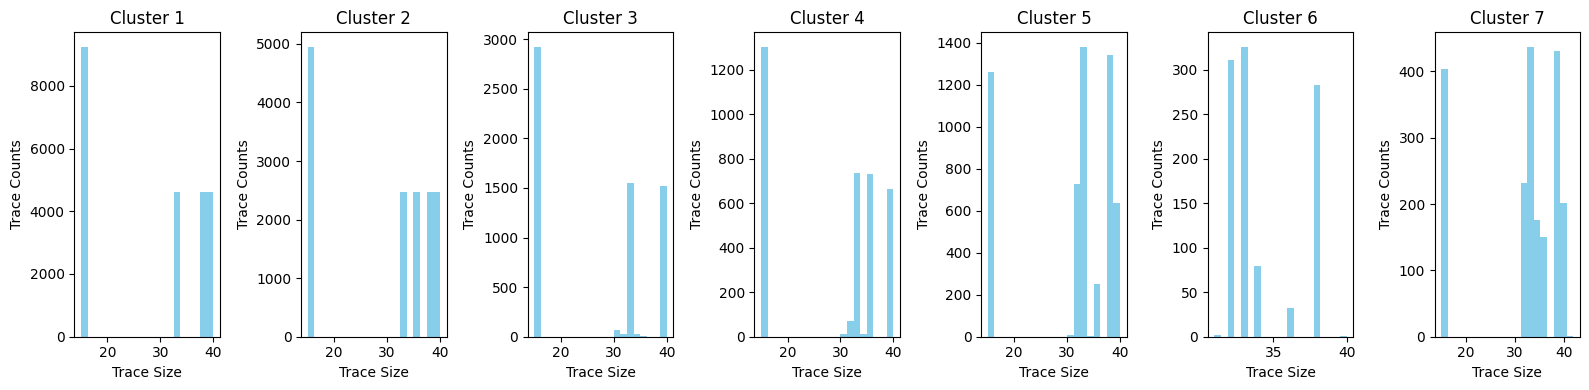

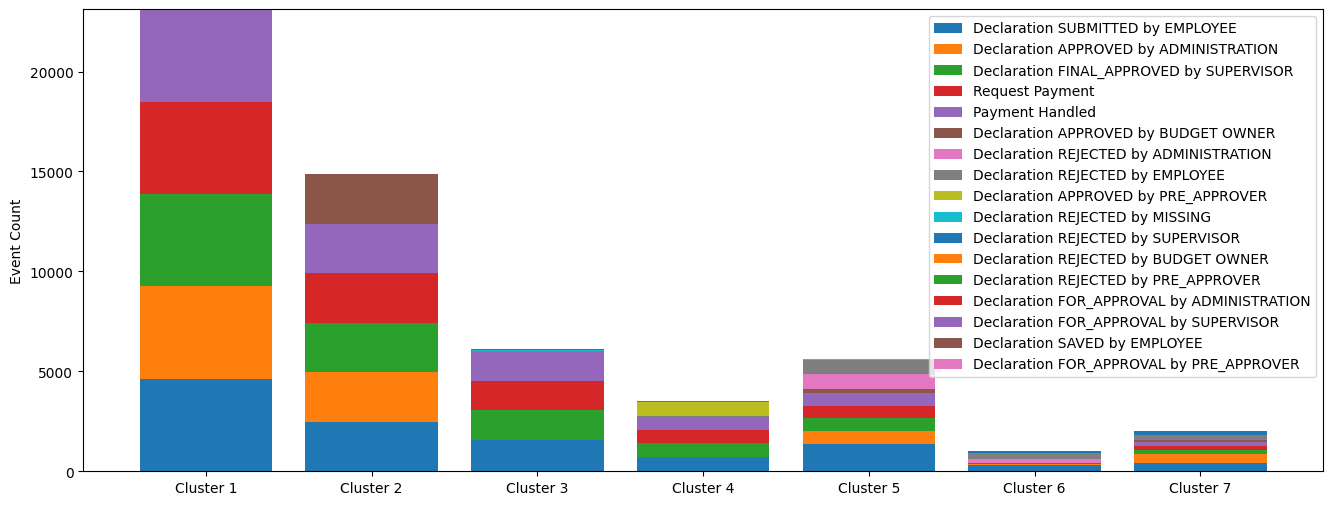

In [7]:
import matplotlib.pyplot as plt

clusters = list(cluster_sublogs.copy().values())

# Trace Sizes in Each Cluster
plt.figure(figsize=(16, 4))
for i, cluster in enumerate(clusters):
    trace_sizes = [len(trace) for trace in cluster['concept:name']]
    plt.subplot(1, len(clusters), i+1)
    
    plt.hist(trace_sizes, bins=20, color='skyblue')
    plt.title(f'Cluster {i+1}')
    plt.xlabel('Trace Size')
    plt.ylabel('Trace Counts')
plt.tight_layout()
plt.show()


# Event Distribution Across Clusters
event_types = get_activities(event_log)
event_counts_per_cluster = [{event: sum(trace.count(event) for trace in cluster['concept:name']) for event in event_types} for cluster in clusters]

plt.figure(figsize=(16, 6))
bottom = np.zeros(len(clusters))
for event in event_types:
    counts = [cluster[event] for cluster in event_counts_per_cluster]
    plt.bar(range(len(clusters)), counts, bottom=bottom, label=event)
    bottom += np.array(counts)
plt.xticks(range(len(clusters)), labels=[f'Cluster {i+1}' for i in range(len(clusters))])
plt.ylabel('Event Count')
plt.legend()
plt.show()

# Assuming function to calculate event distribution
def calculate_event_distribution(log):
    event_distribution = {}
    for trace in log:
        for event in trace:
            if event not in event_distribution:
                event_distribution[event] = 0
            event_distribution[event] += 1
    return event_distribution

## File Export

Finally, we split the modified log by cluster label and save each sublog to a csv file, which can be used for further analysis.

In [8]:
export_sublogs_to_csv(cluster_sublogs)

Clusters exported to /base_approach


## Petrinet Visualization of Sublogs

To visualize our result, we use pm4py heuristic miner and task4 vizualizer implementation to visualize created sub models.

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

23114 events, 4623 cases


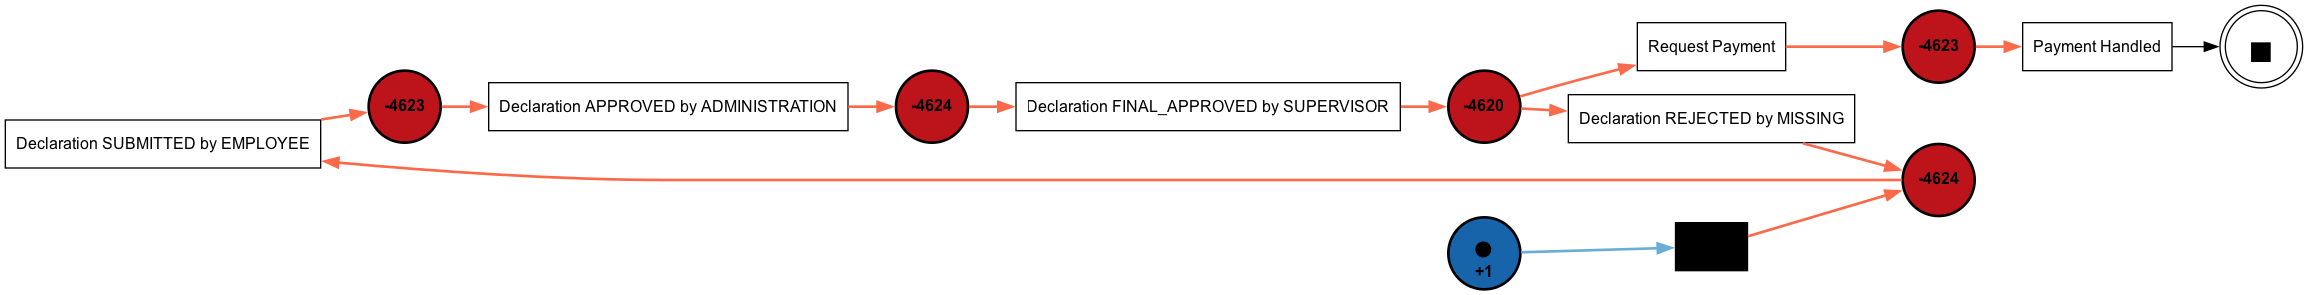

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

14858 events, 2476 cases


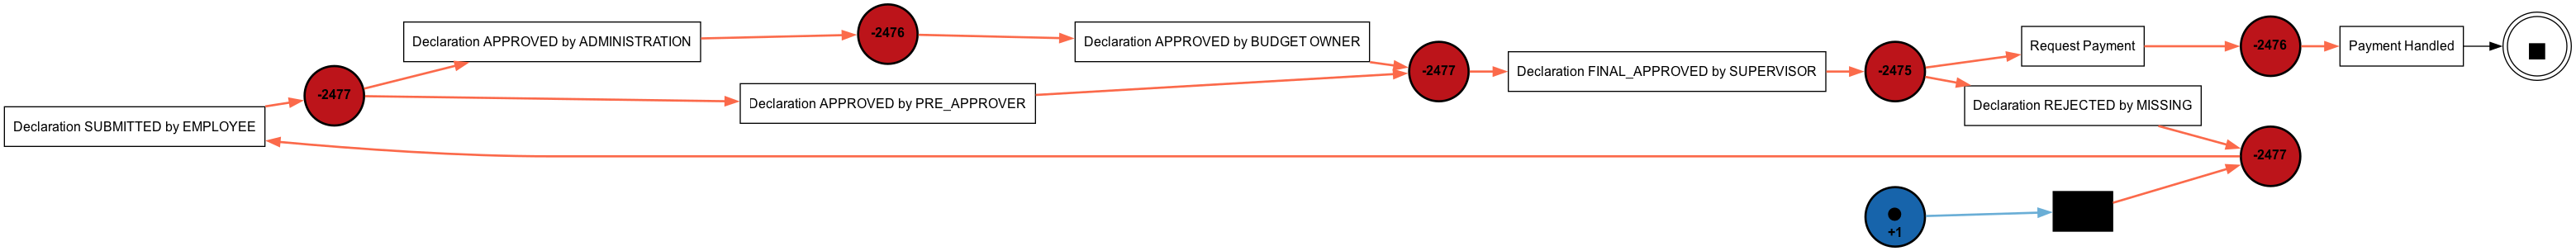

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

6119 events, 1485 cases


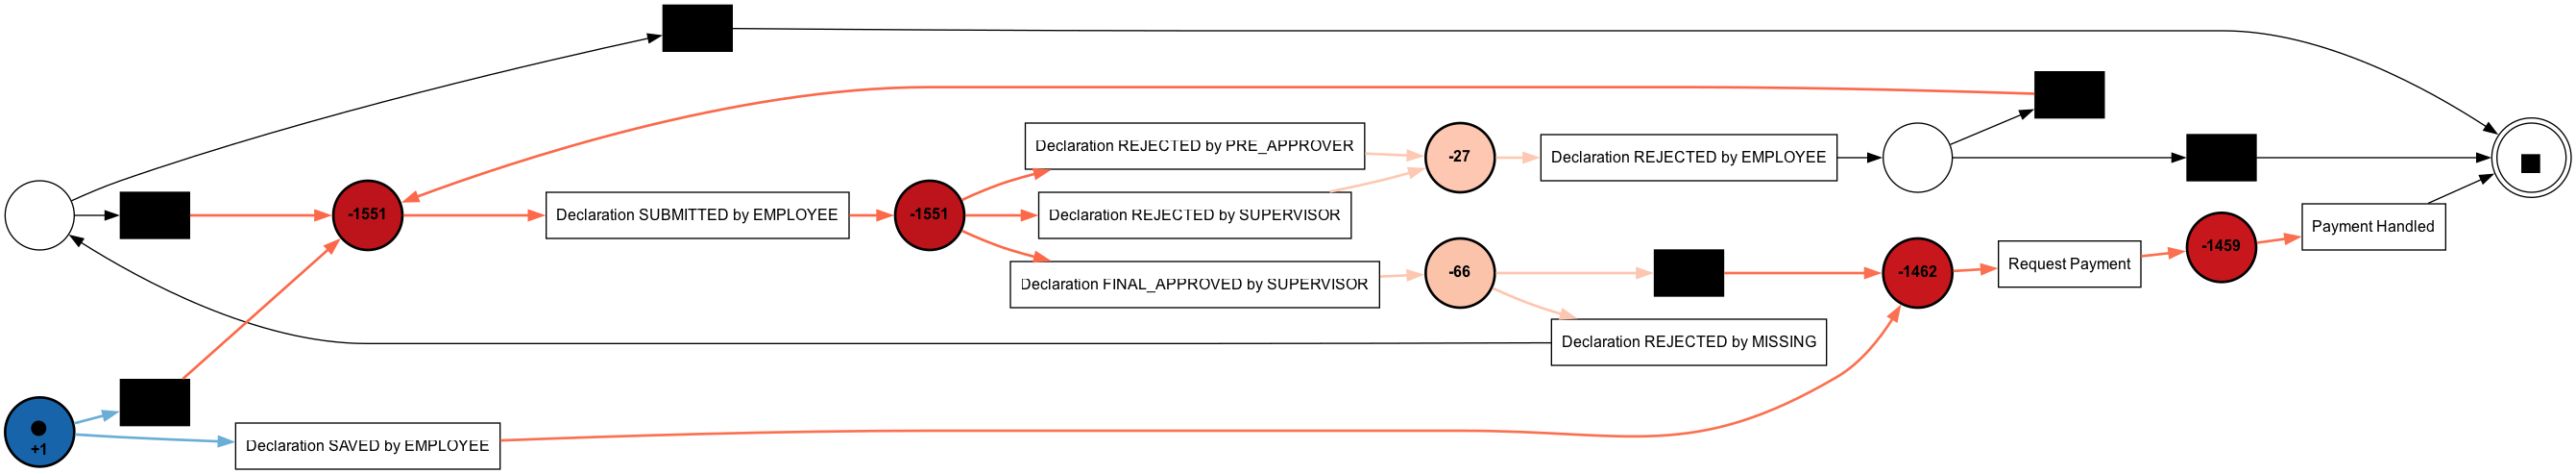

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

3534 events, 655 cases


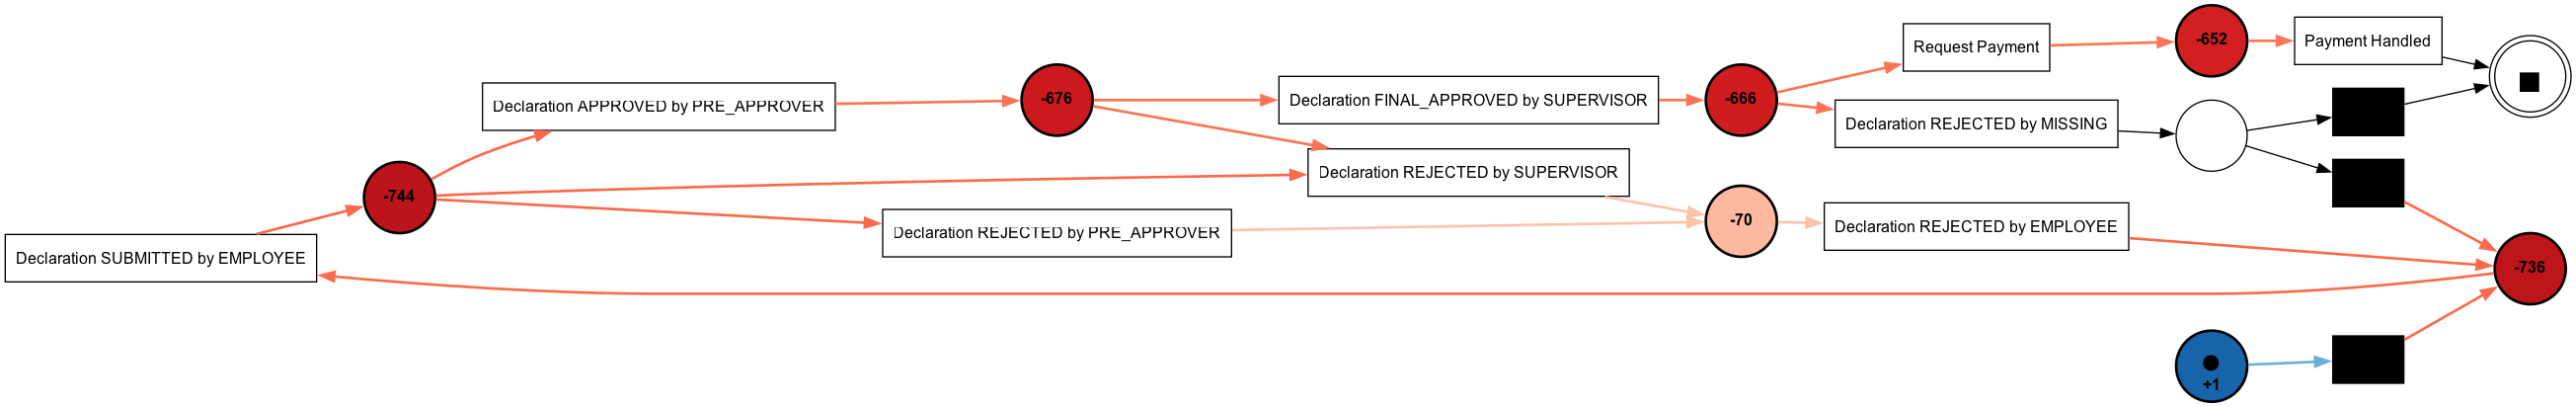

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

5611 events, 633 cases


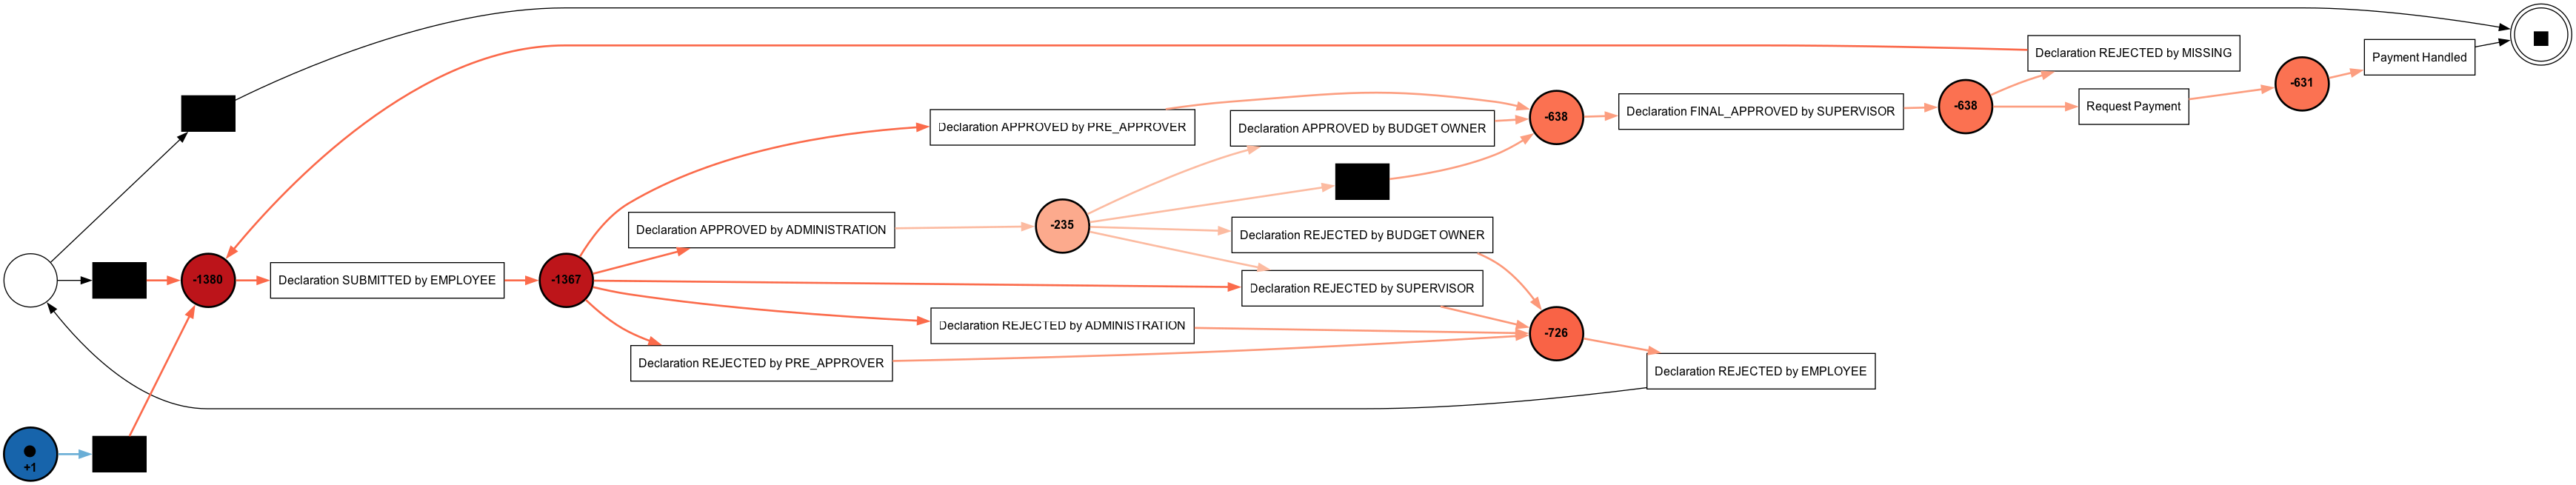

replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

1035 events, 290 cases


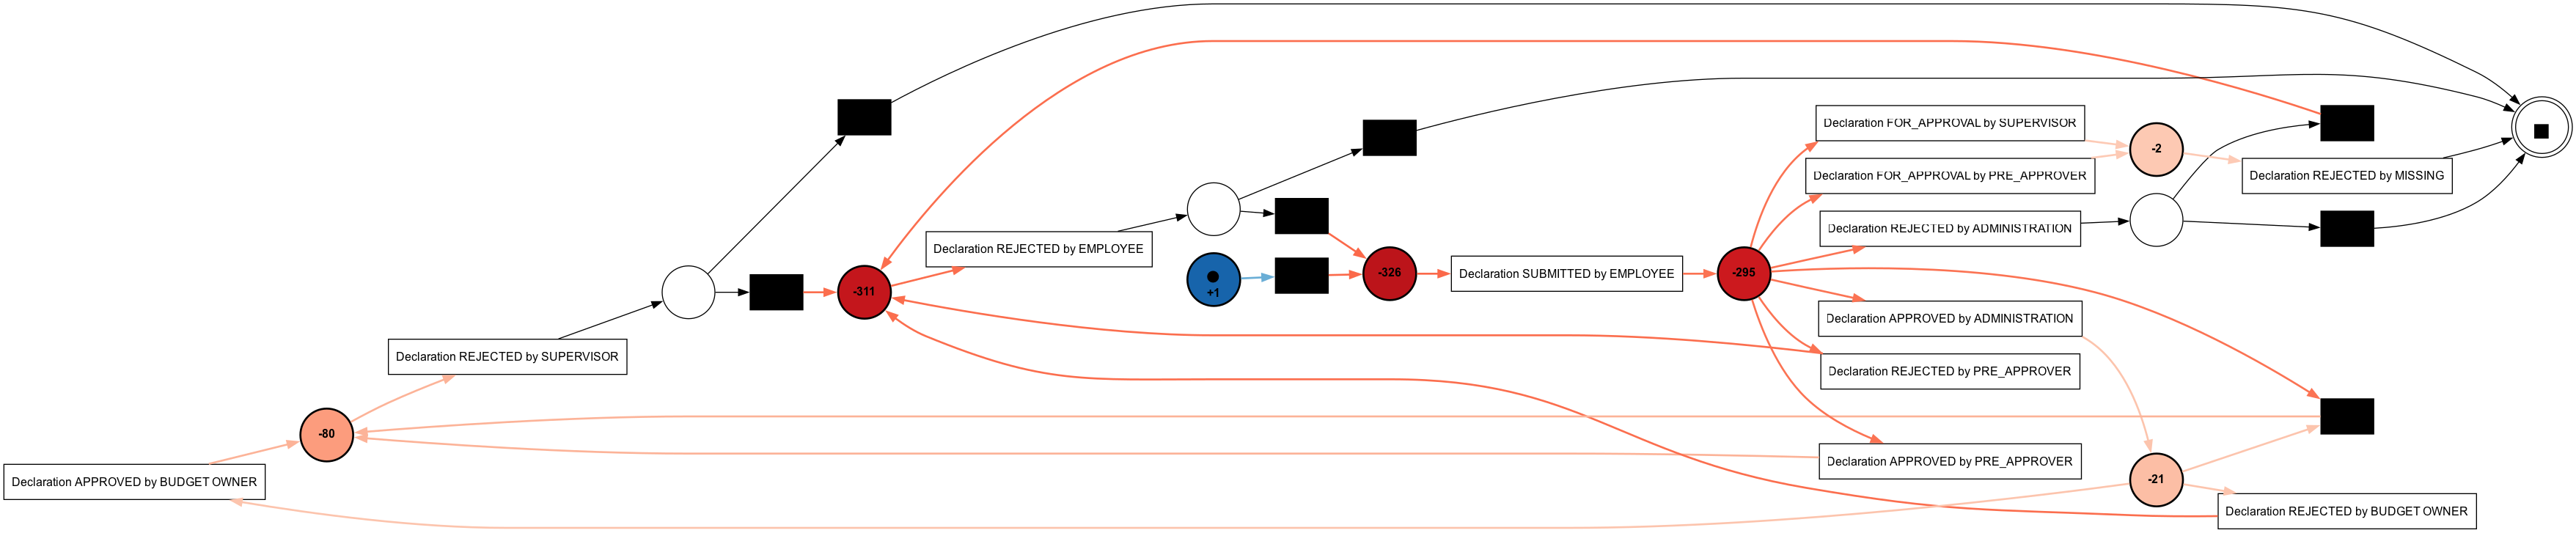

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

2032 events, 204 cases


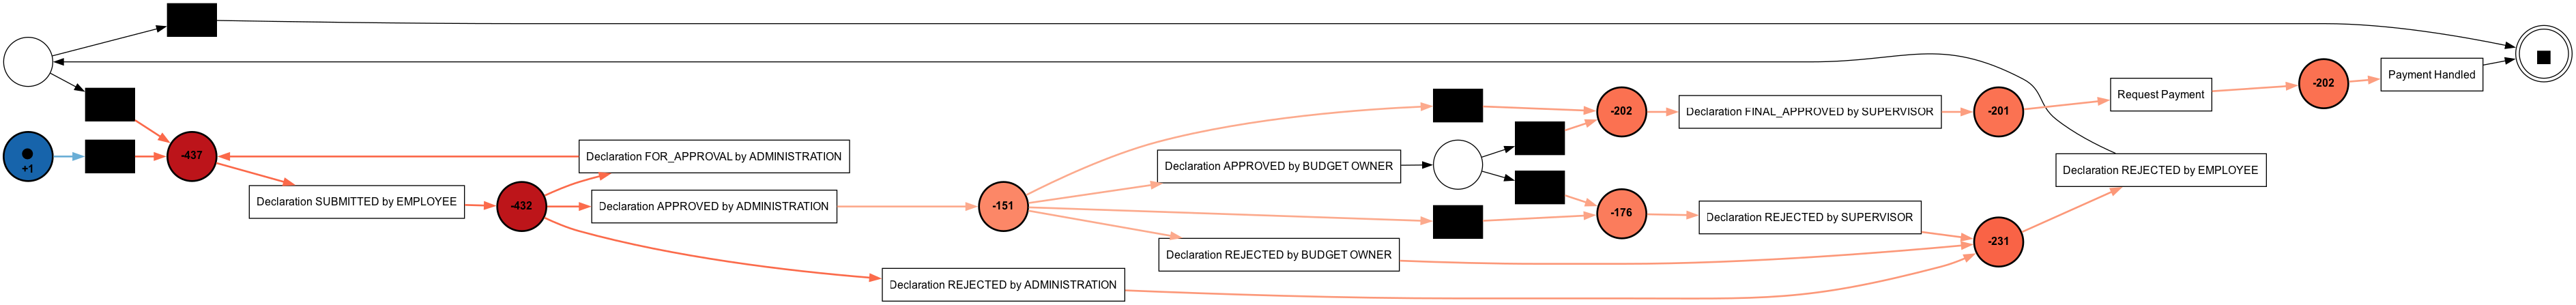

In [9]:
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay

def visualize_single_log(_cluster, df):
    _event_log = log_converter.to_event_log.apply(df)
    
    net, init, final = heuristics_miner.apply(_event_log)

    heuristics_miner_replay = TokenReplay(_event_log, net, init, final, "Heuristic Miner")

    heuristics_miner_replay.run(_event_log)
    tokens = heuristics_miner_replay.get_unconformity_tokens()

    vizard = Visualizer()
    graph = vizard.build_petri_net(net, init, final, tokens)
    print(f'{df.shape[0]} events, {df["case:concept:name"].unique().shape[0]} cases')

    vizard.display(graph)

def visualize_sublogs(_cluster_sublogs):
    for cluster_label, df in _cluster_sublogs.items():
        visualize_single_log(cluster_label, df)

visualize_sublogs(cluster_sublogs)

# Log Version Comparison

To compare the clustering results of the different versions of the event log, we visualize the clusters of each version side by side.
The clusters are sorted by the number of traces in each cluster, but there is no guarantee that the same cluster in different versions has the same label.


In [10]:
step0 = []
for log in LOG_VERSIONS:
    event_log_sampled = event_log_preprocessed.sample(n=1000)
    traces = get_df_by_traces(event_log_sampled)
    encoded_log = hot_encode_traces(log, traces)
    step0.append({"sample": event_log_sampled, "encoded": encoded_log, "traces": traces})

step1 = []
for i, log in enumerate(LOG_VERSIONS):
    best_params = param_grid_tuning(sample_log=step0[i]["sample"], _encoded_log=step0[i]["encoded"])
    step1.append(best_params)

step2 = []
for i, log in enumerate(LOG_VERSIONS):
    event_log, cluster_labels = apply_kmeans(params=step1[i], _event_log=log, _traces=step0[i]["traces"])
    step2.append({"event_log": event_log, "cluster": cluster_labels})
    
step3 = []
for i, log in enumerate(LOG_VERSIONS):
    cluster_sublogs = split_by_cluster(_event_log=step2[i]["event_log"])
    step3.append(cluster_sublogs)

aligning log, completed variants :: 100%|██████████| 41/41 [00:00<00:00, 117.49it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 532.20it/s]
aligning log, completed variants :: 100%|██████████| 41/41 [00:00<00:00, 118.29it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 388.75it/s]
aligning log, completed variants :: 100%|██████████| 41/41 [00:00<00:00, 93.44it/s]:00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 419.19it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 385.11it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 280.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 632.16it/s]
aligning log, completed variants :: 100%|██████████| 41/41 [00:00<00:00, 157.36it/s]
computing pr

Best Score: 0.9522341094113438
Best Params: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 7, 'n_init': 20}


aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 294.11it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 663.45it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 229.03it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 550.14it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 412.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 147.88it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 127.62it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 510.91it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 440.46it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 152.70it/s]:00<?, ?it/s]

Best Score: 0.9566987117727919
Best Params: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 7, 'n_init': 10}


aligning log, completed variants :: 100%|██████████| 33/33 [00:00<00:00, 148.35it/s]00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 480.08it/s]
aligning log, completed variants :: 100%|██████████| 33/33 [00:00<00:00, 98.34it/s]:00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 402.37it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 671.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 711.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 469.79it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 455.09it/s]
aligning log, completed variants :: 100%|██████████| 33/33 [00:00<00:00, 170.82it/s]00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|█████████

Best Score: 0.9807547536350416
Best Params: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 7, 'n_init': 10}


Version: full span - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

23114 events, 4623 cases


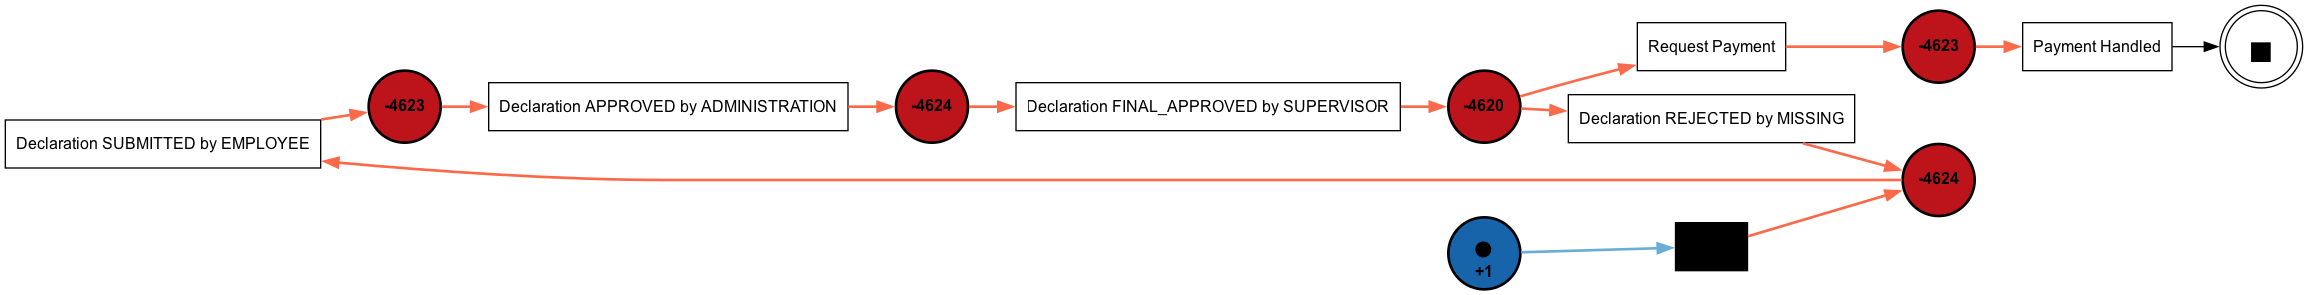

Version: from 2018 - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

23153 events, 4643 cases


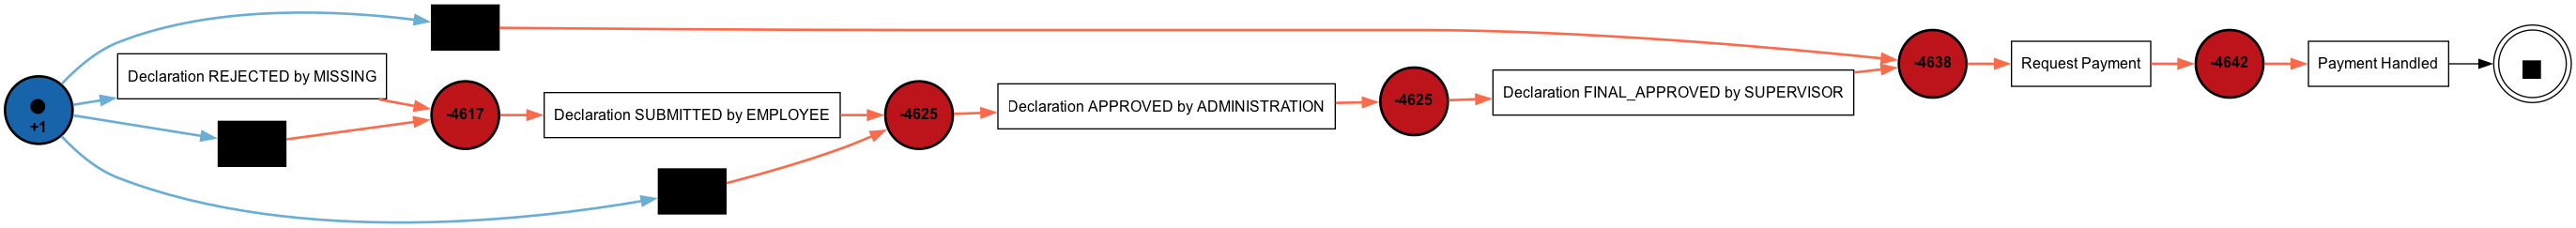

Version: before 2018 - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

5395 events, 1349 cases


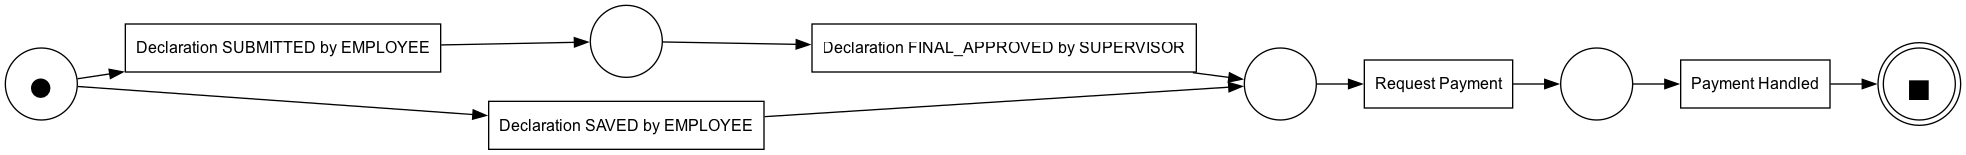








Version: full span - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

5611 events, 633 cases


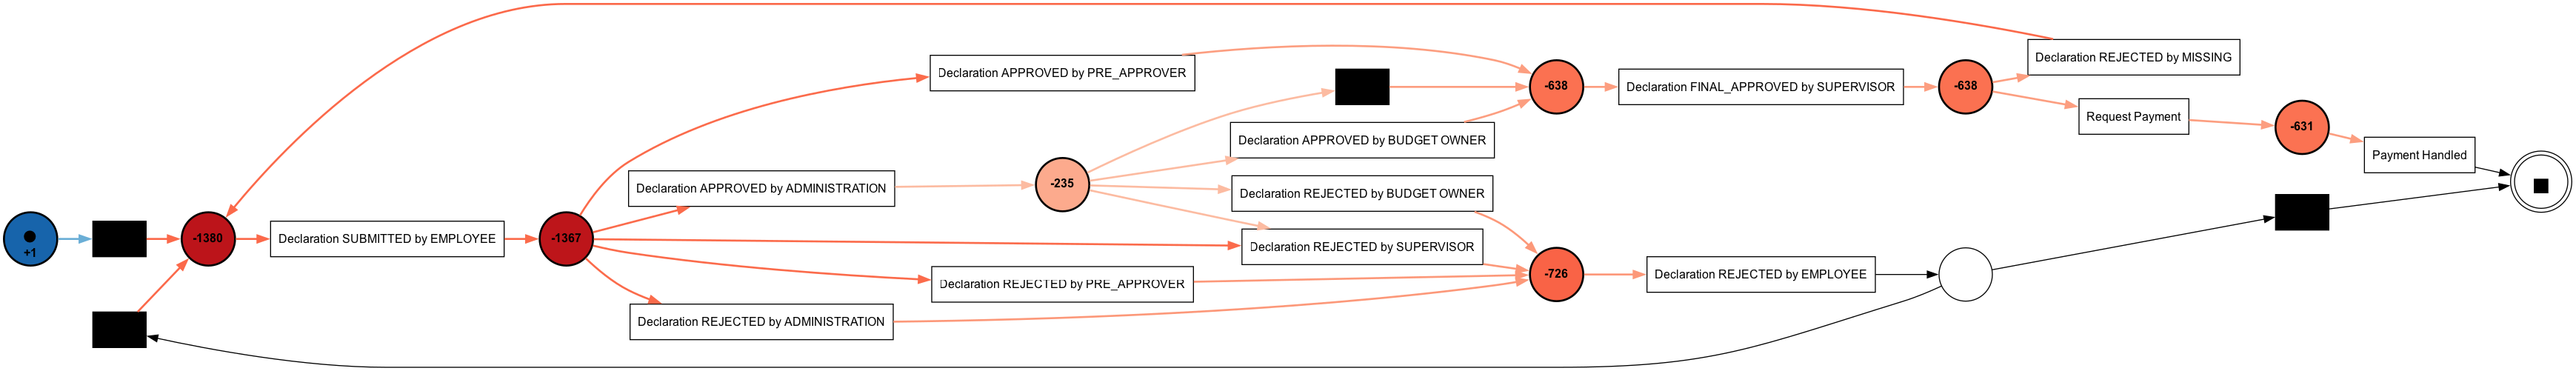

Version: from 2018 - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

14858 events, 2477 cases


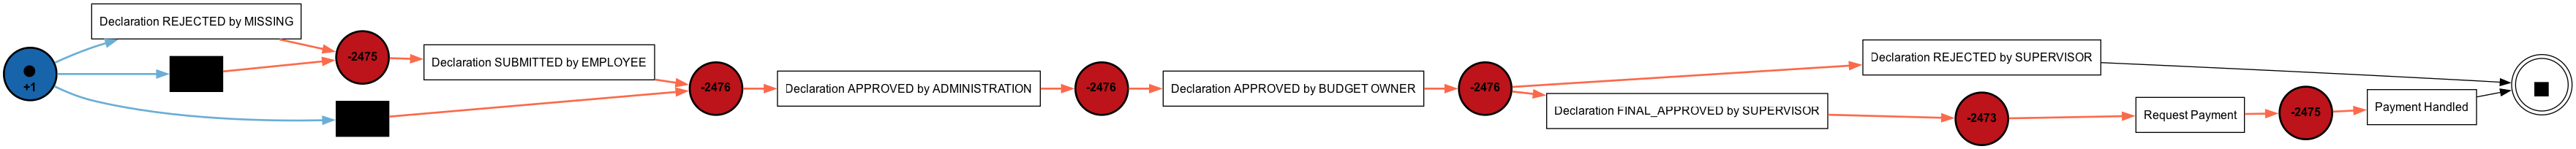

Version: before 2018 - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

2847 events, 571 cases


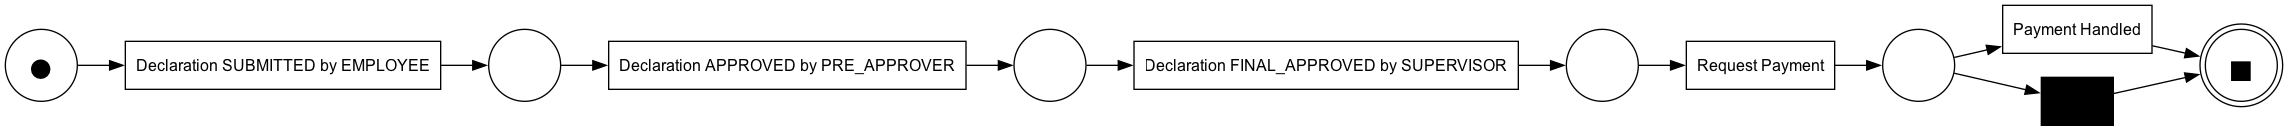








Version: full span - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

14858 events, 2476 cases


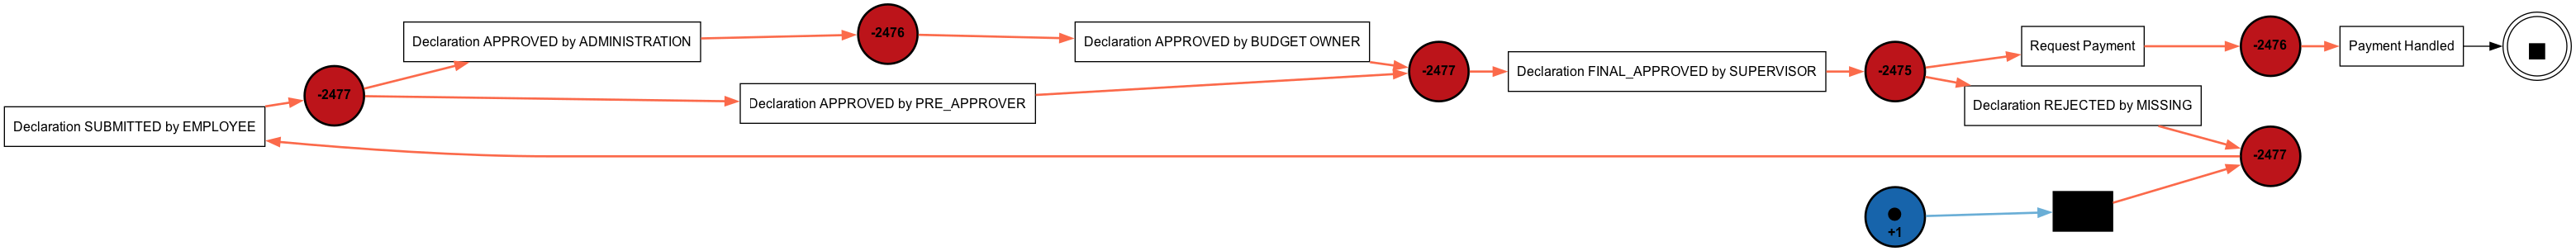

Version: from 2018 - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

2786 events, 348 cases


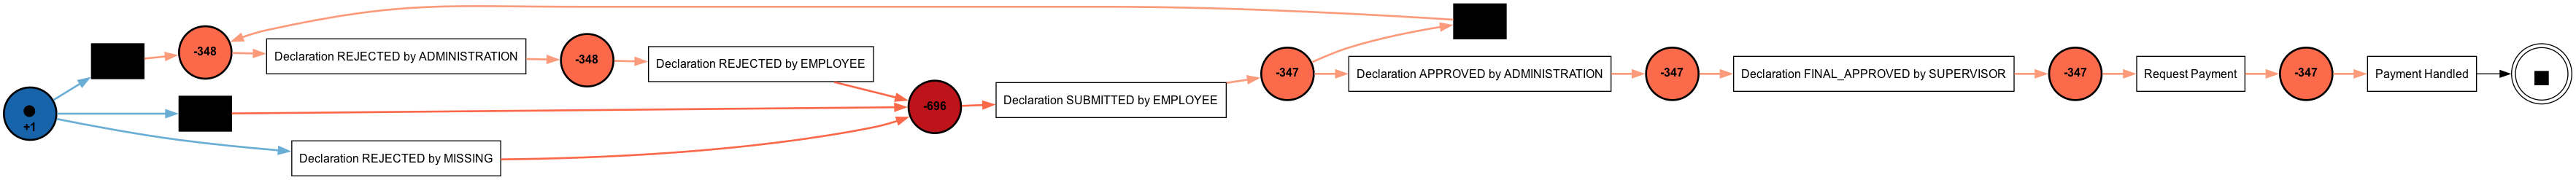

Version: before 2018 - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

135 events, 39 cases


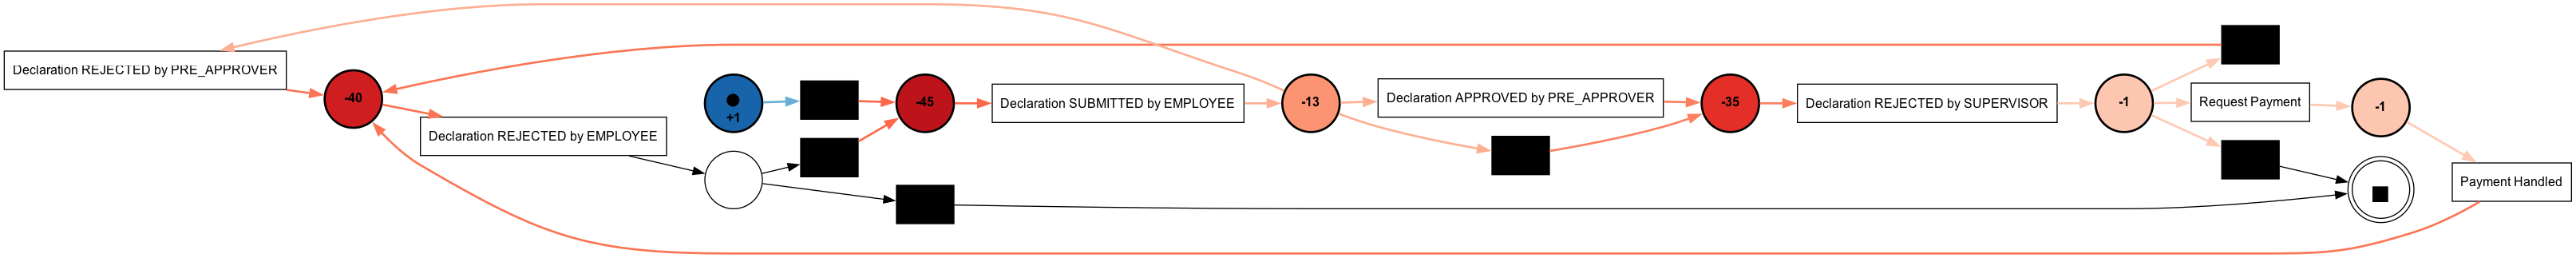








Version: full span - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

3534 events, 655 cases


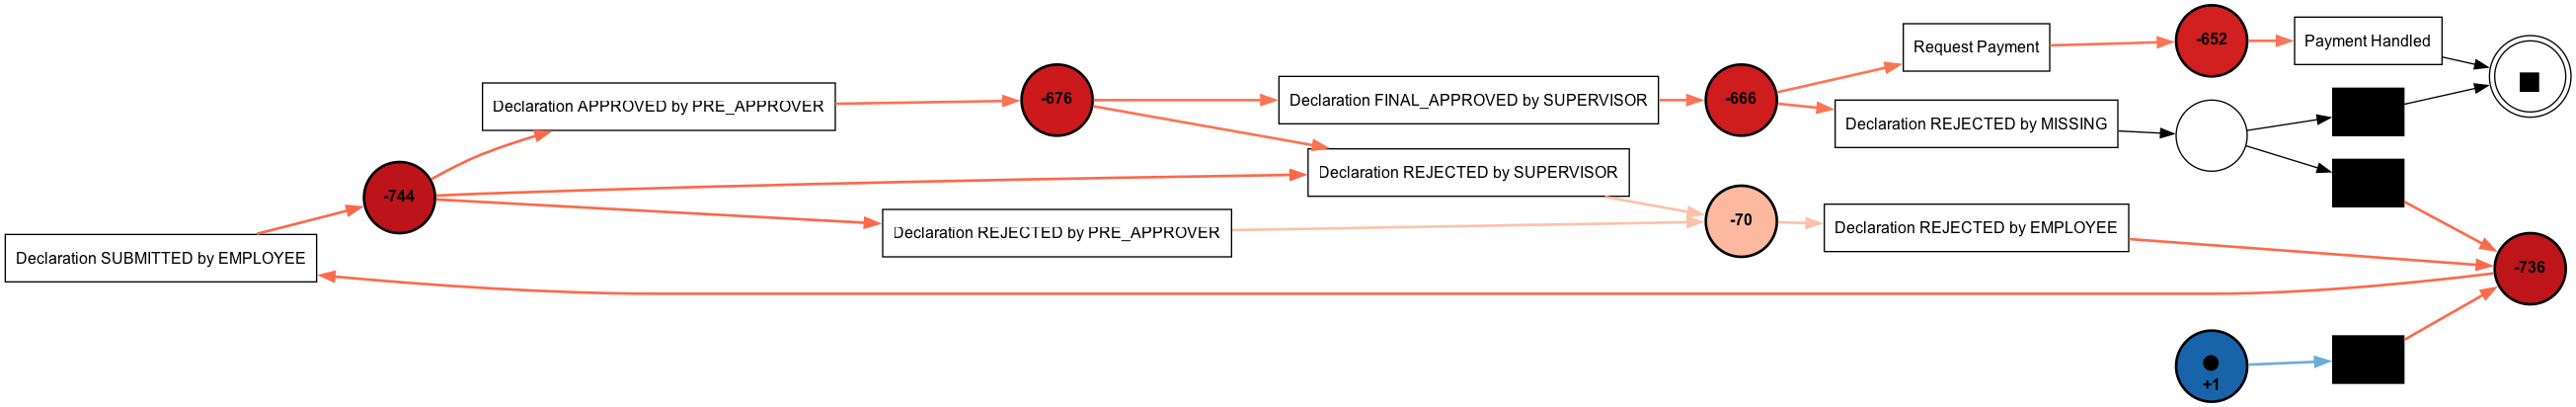

Version: from 2018 - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

892 events, 251 cases


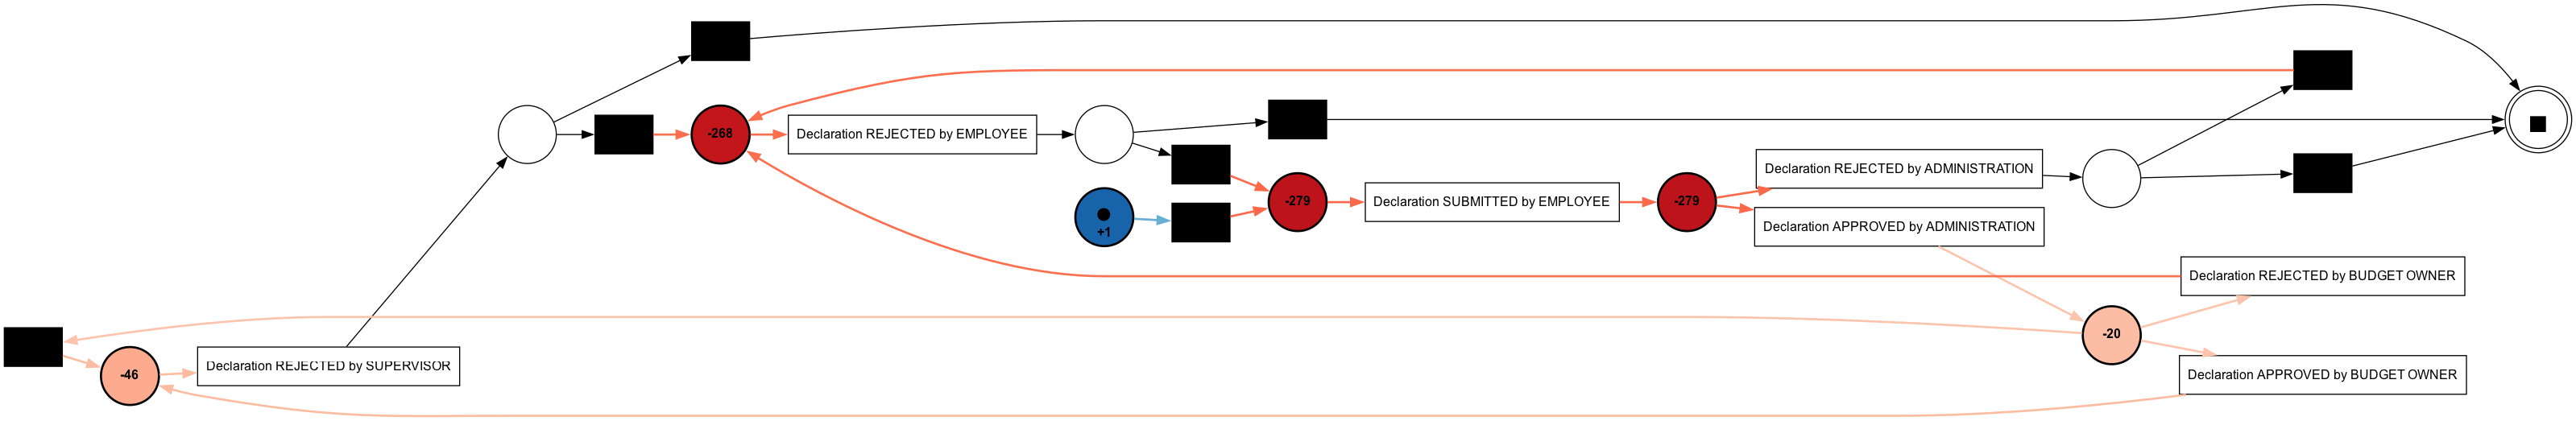

Version: before 2018 - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

587 events, 71 cases


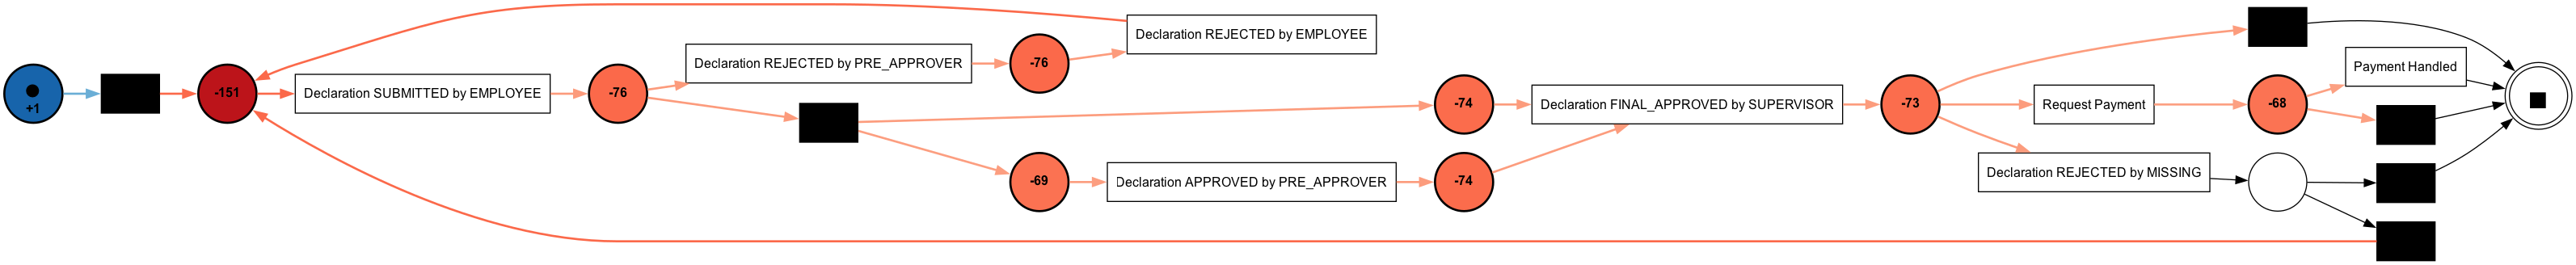








Version: full span - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/136 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

2032 events, 204 cases


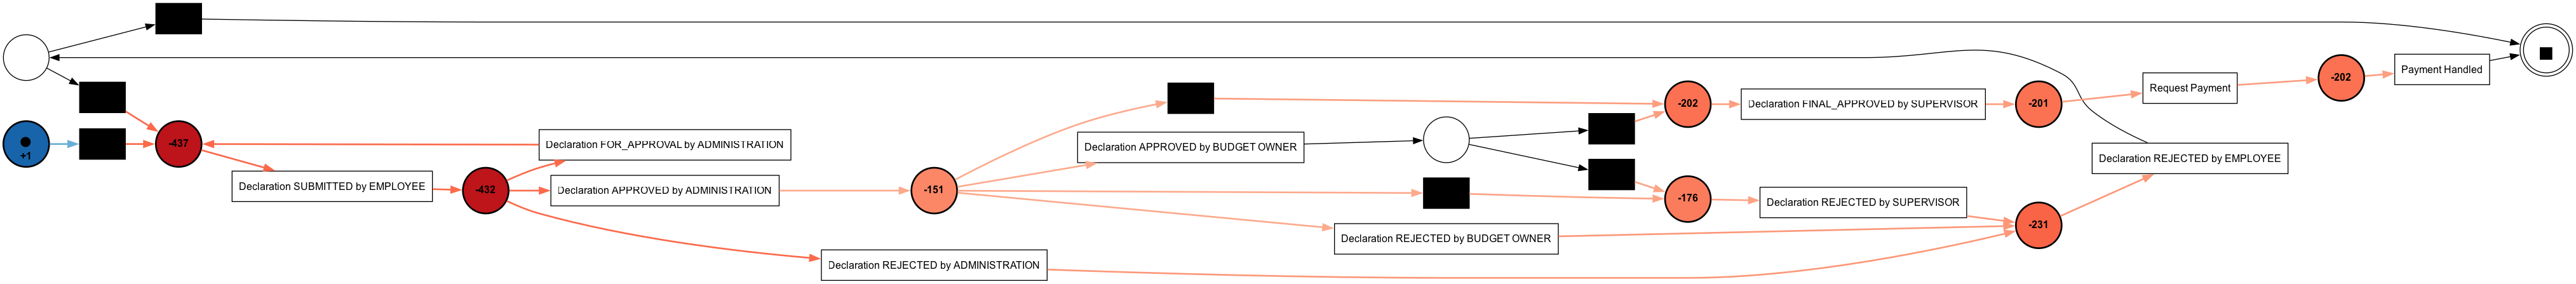

Version: from 2018 - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

1785 events, 185 cases


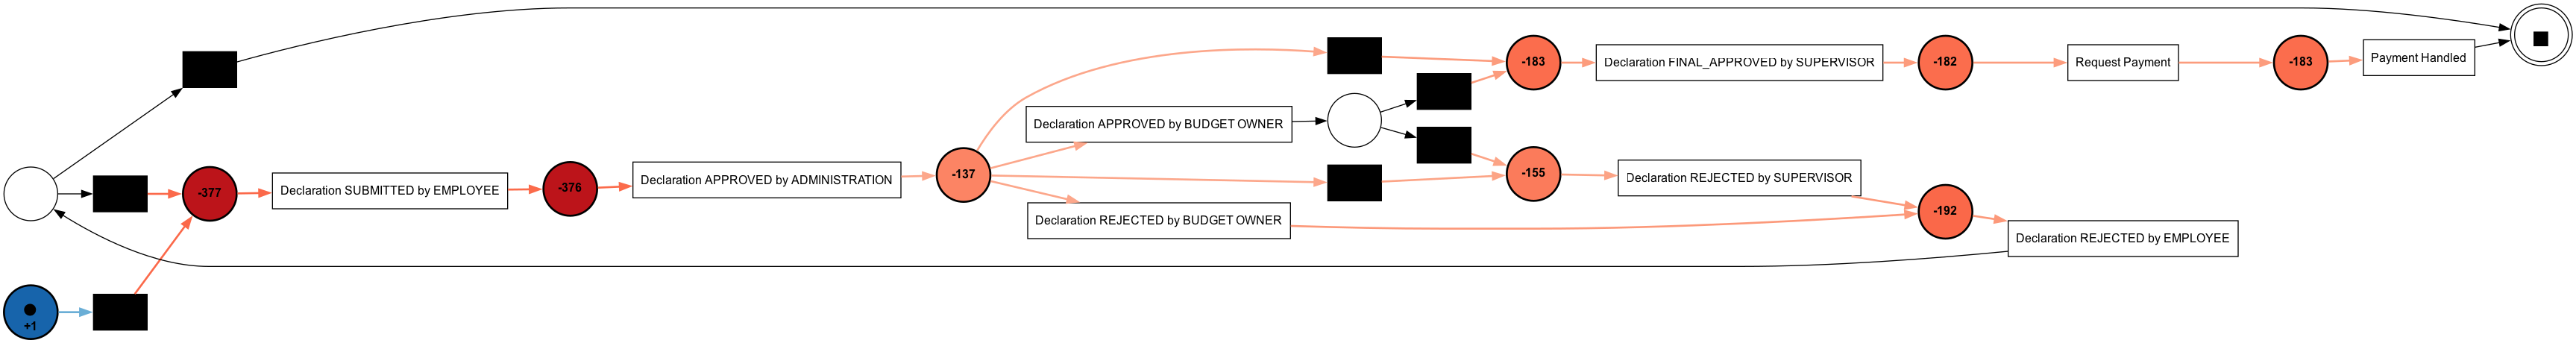

Version: before 2018 - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

392 events, 52 cases


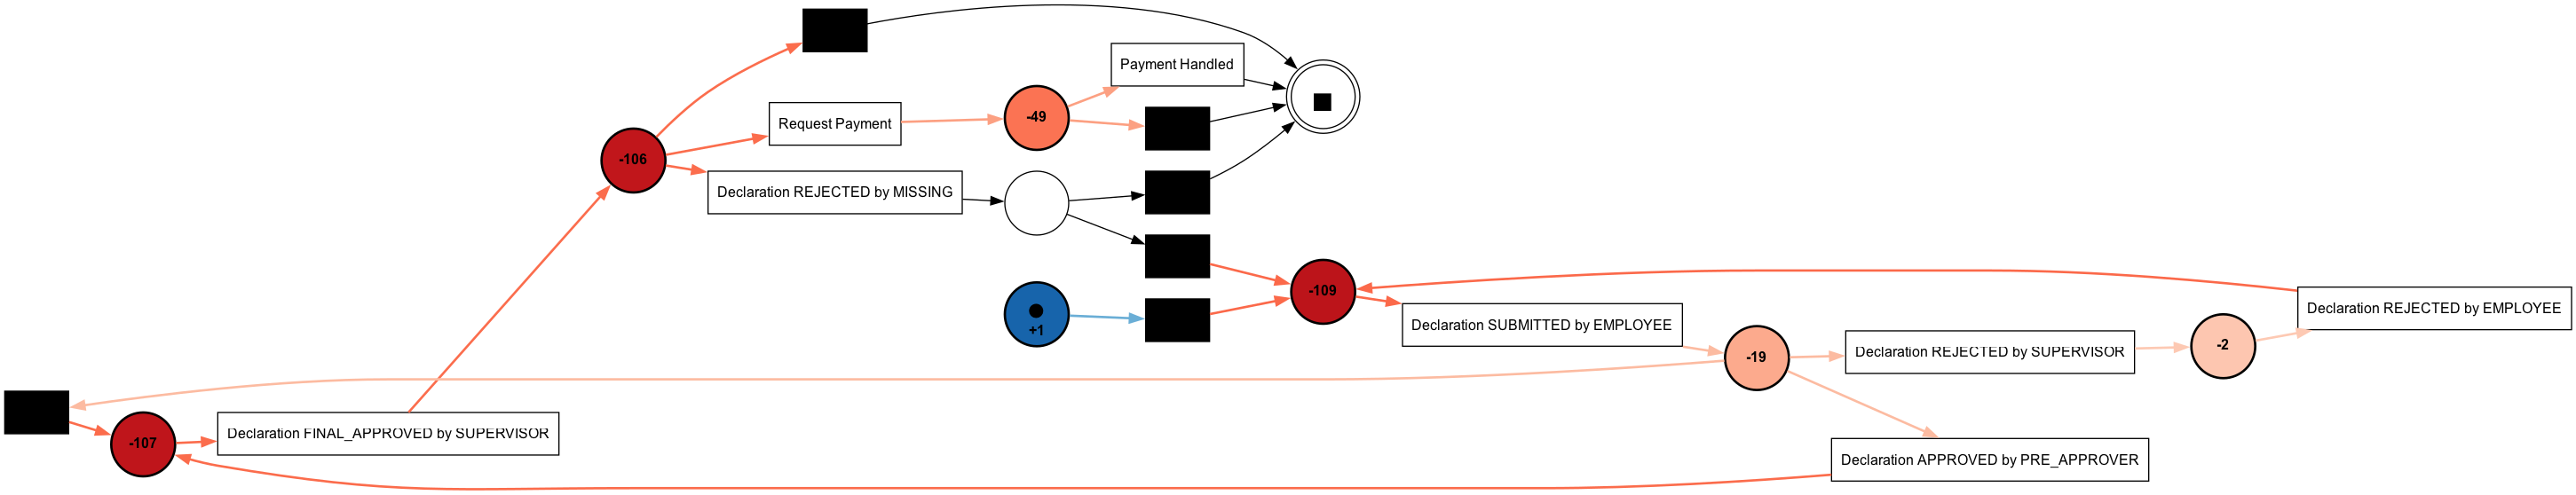








Version: full span - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/24 [00:00<?, ?it/s]

1035 events, 290 cases


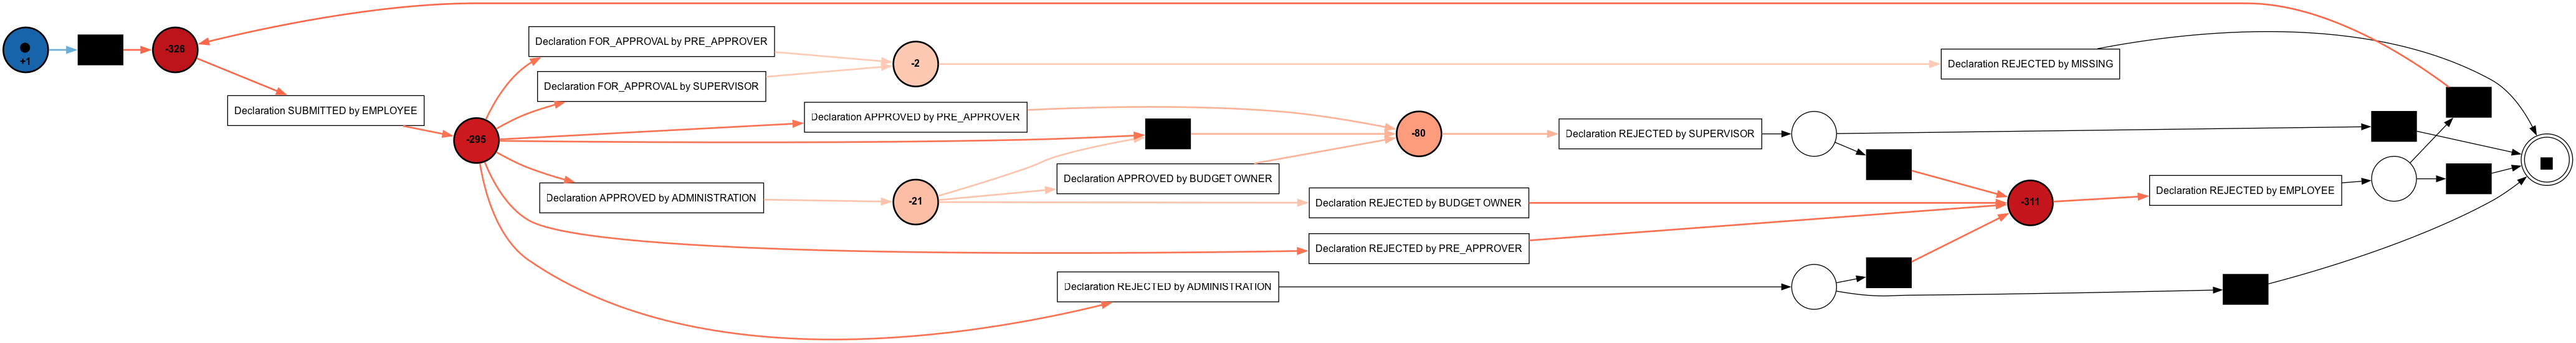

Version: from 2018 - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

1700 events, 189 cases


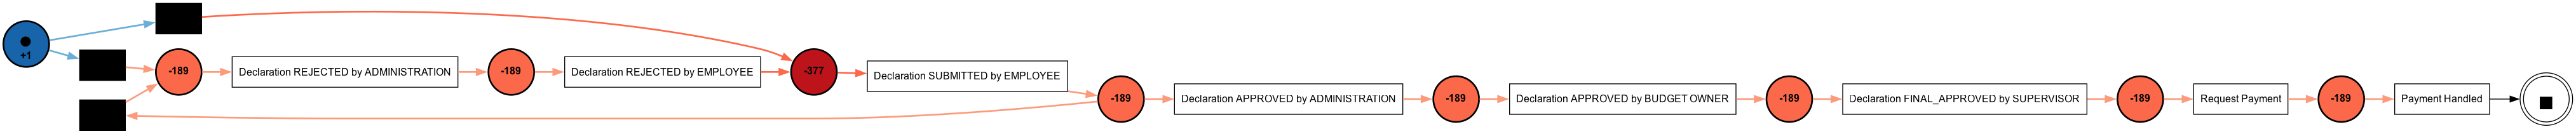

Version: before 2018 - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

251 events, 33 cases


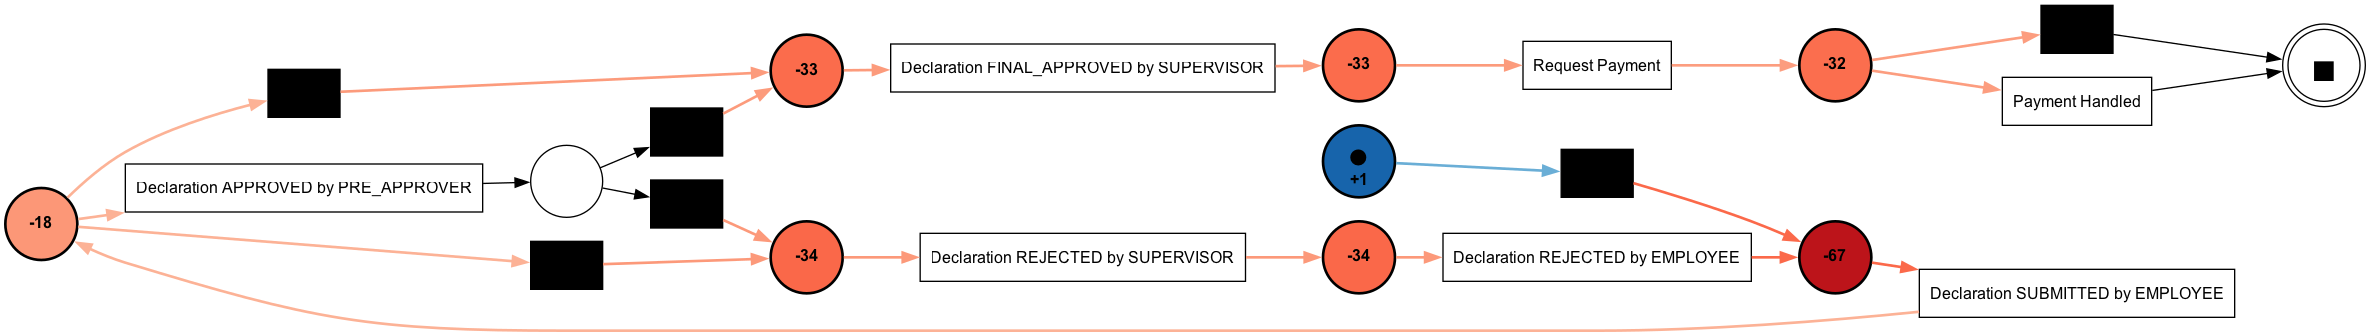








Version: full span - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

6119 events, 1485 cases


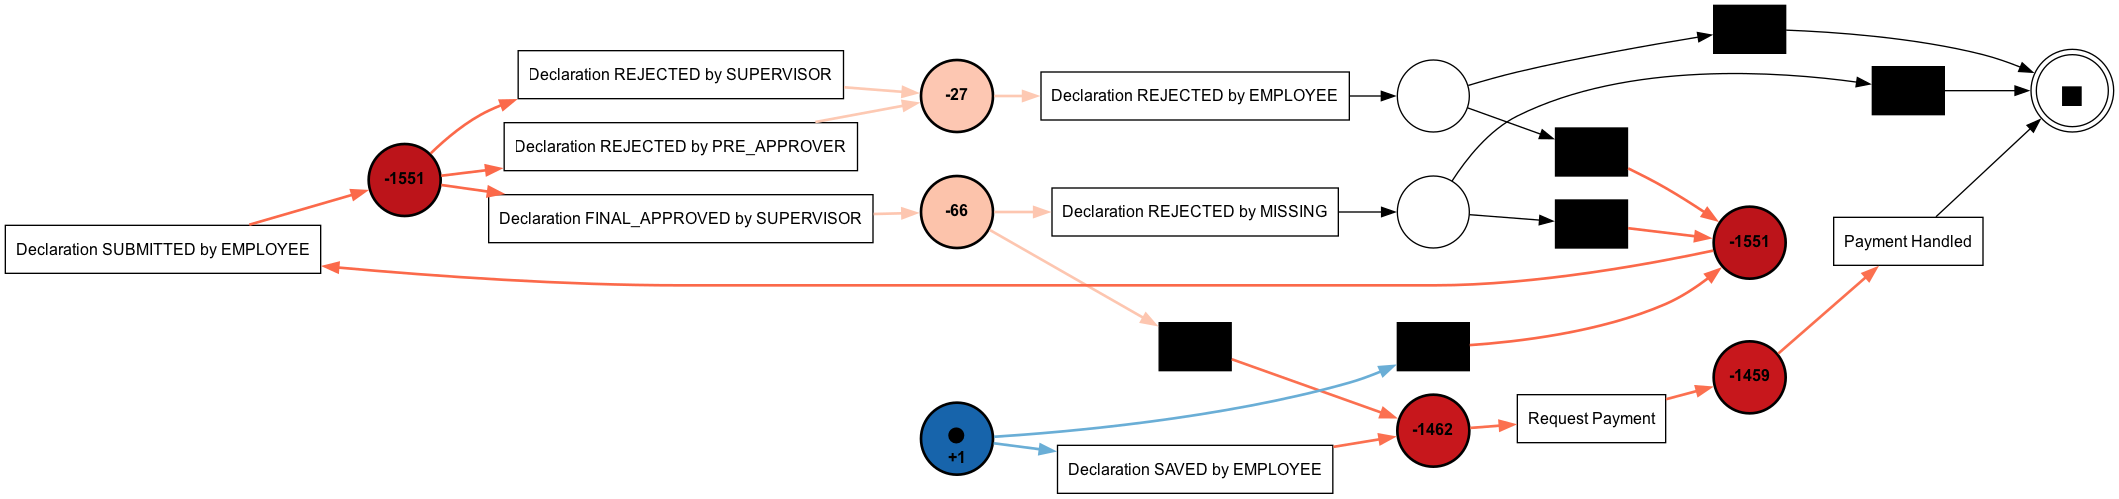

Version: from 2018 - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

1232 events, 102 cases


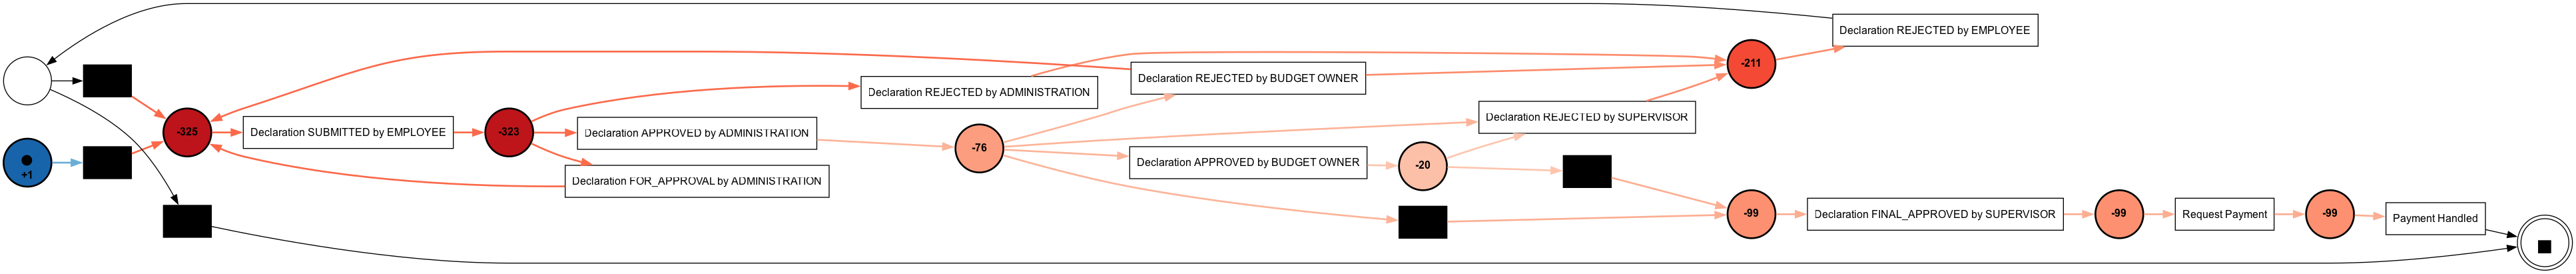

Version: before 2018 - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

228 events, 79 cases


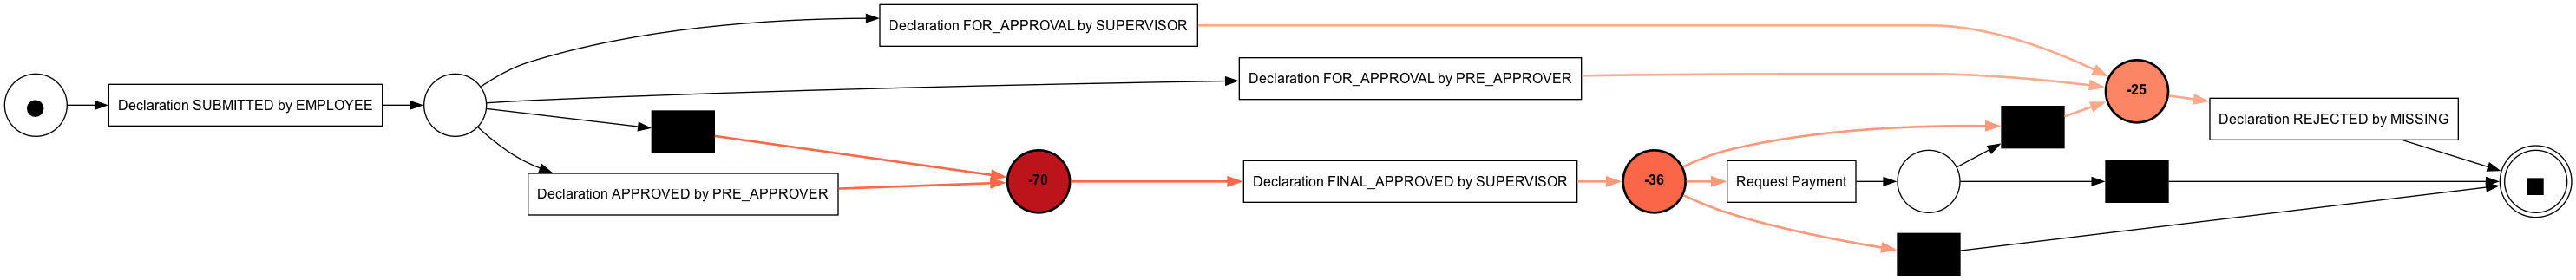

In [11]:
for x in range(len(step3[0])):
    for j, log in enumerate(LOG_VERSIONS):
        if j == 0:
            name = "full span"
        elif j == 1:
            name = "from 2018"
        else:
            name = "before 2018"
        print(f"Version: {name} - Cluster: {x}")
        visualize_single_log(_cluster=step3[j][x], df=step3[j][x])
    print("\n\n\n\n\n\n")